# Proyecto Final Área Imágenes: 
EL5206 Laboratorio de Inteligencia Computacional y Robótica
- Profesor: Claudio Pérez F
- Profesor Auxiliar: Juan Pablo Pérez
- Estudiantes: Pablo Yáñez M, Magdalena De La Fuente

## Content Based Image Retrieval (CBIR)
El Content Based Image Retrieval consiste en una técnica para la búsqueda de imágenes dentro de una base de datos a partir de las características presentes en las imágenes. Estas características pueden ser extraídas a través de distintos algoritmos. 

* **Objetivo del Proyecto**

El objetivo de este proyecto final es desarrollar e implementar un algoritmo de búsqueda de imágenes similares basado en su contenido (Content Based Image Retrieval, CBIR) utilizando distintos métodos de extracción de características. 

* **Sobre las imágenes**

Se utilizan los datasets INRIA Holidays dataset y GPR1200. El primero consiste en imágenes de consulta para 500 clases, mientras que el segundo consta de 1200 clases con 10 ejemplos por clase. 

* **Sobre el trabajo realizado**
  
En este informe se aborda la implementación de distintos métodos para atacat la problemática CBIR. 

El primer método consiste en la construcción de un método de obtención de vectores característicos "handcrafted", en donde se utiliza un modelo de Bag of Visual Words. Este obtiene descriptores provisos por el algoritmo SIFT, luego clusteriza estos descriptores y finalmente encuentra las palabras visuales. Esta información es finalmente proyectada en un histograma, y estos histogramas se almacenan en un archivos .csv. Por cada imagen del dataset hay un histograma. 

El segundo método implementado utiliza redes neuronales convolucionales para generar vectores característicos. Se proveen las imágenes a la red XXX rellenar con detalles. 

El tercer método implementado correponde a la fusión de los vectores característicos del método handcrafter y el método por CNN. Estos vectores se concatenan para formar un solo vector característico por imagen, y luego son enviados a un proceso de LDA para reducir la dimensionalidad, obteniéndose finalmente, un vector unimidensional más corto que CNN pero más largo que a través del método hand crafted.

El cuarto?

* **Sobre el código implementado**

Todas las funciones implementadas han sido empaquetadas para hacer uso de estas de manera fácil en múltiples archivos o notebooks. Los modulos se pueden encontrar en la carpeta src del respositorio. 



In [1]:
 import pandas as pd
from PIL import Image 
from src.SIFT.SIFT_gen_and_utils import SIFTFeatures 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
from src.Metrics.metrics_utils import get_hist_from_str, plot_10, similarity_matrix, plot_histogram, similarity_metric, query_image, evaluate_query, precision_recall, query_image_normal
from src.SIFT.SIFT_gen_and_utils import SIFTFeatures 

In [2]:
df = pd.read_csv('/mnt/c/Users/pyanez/Desktop/pablo/universidad/LabInt/dataset/final_histograms.csv')
SIFT = SIFTFeatures("", "", run=False)

In [3]:
df["class"] = df["image_name"].apply(lambda x: SIFT.get_class(x))
df["features_histogram"] = df["features_histogram"].apply(lambda x: get_hist_from_str(x, separator=' '))
df["features_fusion"] = df["features_fusion"].apply(lambda x: get_hist_from_str(x, separator=','))

In [4]:
#PARAMETROS GLOBALES
IMAGE_EXAMPLE = df["image_name"][0]
MEASURE = 'cosine'
PATH_TO_IMAGES = '/mnt/c/Users/pyanez/Desktop/pablo/universidad/LabInt/dataset/total'

### Método Handcrafted

El método handcrafted consiste de cuatro pasos:

#### 1. Generación de decriptores por SIFT

El algoritmo *Scale Invariant Feature Transform (SIFT)* es un algoritmo de visión computacional de extraccion de características para imágenes. Como dice su nombre, es invariante a la escala y rotación de una imagen. Se utiliza en una variedad de aplicaciones, entre ellas el reconocimiento de objetos, mapeo robótico, navegación, modelamiento 3d, etc. 

Este algoritmo retorna una lista de valores descriptores que corresponden a posiciones en la imagen que cumplen alguna particularidad.  En esta ocasión se fijó el numero de descriptores a generar por imagen en 10000. Se utiliza la funcion `cv2.SIFT_create` y luego `sift.detectAndCompute` para calcularle los descriptores a cada imagen. Como mencionado antes la ventaja de utilizar SIFT es la invarianza de los descriptores a la rotación y escalamiento, sin embargo, una desventaja es que no es sensible al color, ya que las imágenes son convertidas a escala de grises antes de computar los descriptores. Esto a la vez lo vuelve sensible al constraste de la imagen. 

#### 2. Obtención de clusters por Kmeans 
Debido al alto volumen de datos generado por SIFT, solo se utiliza un subconjunto de imagenes para construir los clusteres de palabras. Por supuesto, el subconjunto a sido balanceado y estratificado para evitar problemas asociados al desbalance de clases. Se utilizó un subsampling de 0.35, es decir, 35% de la data total. Numéricamente esto corresponde a 472185 imágenes de un total de 13491. 

En Kmeans se debe elegir un número de clusters a encontrar por el algoritmo. Uno de los métodos más comunes para seleccionar el número de clusters es el método del codo. Este consiste en encontrar el punto de inflexión en una curva de pérdida SSE (sum of squared errors).

En esta ocasión el número de clusters es 120. 

#### 3. Cuantización Obtencion de palabras visuales
Para obtener las palabras visuales se obtienen los 120 centroides generados en la sección 2. Luego, para la data no perteneciente al subconjunto mencionado antes, se asocia cada datapoint a el cluster correspondiente. Esta metodología permite reducir significativamente los tiempos de computo para un dataset de gran tamaño.   

#### 4. Construcción de histogramas
El último paso en este método es la construcción de histogramas. Se utiliza la funcion `np.histogram` de numpy para construir un histograma donde el número de bins es el número de clusters obtenido por el método del codo anteriormente.



#### Plot de un histograma handcrafted

A continuación se muestra el histograma generado para una imagen del dataset utilizando el método handcrafted. Tiene 120 bins, correspondiente al número de clusters señalado por el método del codo.

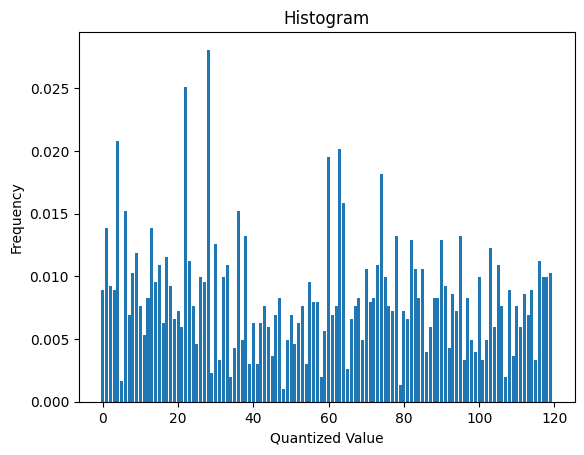

In [5]:
plot_histogram(df, 0, 120,feature_type="histogram")

Para consultar una imagen, se utiliza la función query_image. Esta función recibe una base de datos (dataframe), la medida de similitud y el tipo de feature a utilizar. Internamente, calcula la similitud entre la imagen de consulta y el resto de las imágenes en la base de datos. Finalmente ordena el dataset según menor similitud.

In [6]:
df_query_hand = query_image_normal(df, IMAGE_EXAMPLE, measure=MEASURE, feature_type = "histogram")
df_query_hand.head()

,image_name,features_histogram,features_CNN,class,features_fusion,similarity
0,0_430b273cb7915d83.jpg,"[0.00891516, 0.01386802, 0.00924535, 0.0089151...","[0.029053611680865288, 0.005296911112964153, 0...",0_type1,"[-2.613821, 2.5879636, -0.439339, 2.8203344, -...",0.000000
1,283_48d56dde4ff947636e6d2e88fe0944d7.jpg,"[0.00996485, 0.00996485, 0.00996485, 0.0101602...","[0.020358193665742874, 0.0023548284079879522, ...",283_type1,"[-1.1635916, 1.606958, 0.5549883, -1.4256543, ...",0.054444
2,445_sketch_32.JPEG,"[0.00770769, 0.01268805, 0.00889349, 0.0088934...","[0.021581431850790977, 0.008826437406241894, 0...",445_type1,"[-3.5754519, -0.30903798, -0.76512164, 0.64123...",0.060710
3,48_5242ac0bf47e7b3a.jpg,"[0.01037963, 0.00834883, 0.00947705, 0.0094770...","[0.00839096587151289, -0.0010573659092187881, ...",48_type1,"[-0.3229542, 2.5111763, -0.59074354, -0.147908...",0.061331
4,302_592813d0442d8954ad830cf27415c95c.jpg,"[0.00871297, 0.00789099, 0.01512441, 0.0096993...","[0.014047221280634403, 0.0009004293824546039, ...",302_type1,"[0.88486856, 1.4879302, -2.5667968, -1.0931183...",0.061934


Una vez ordenado el dataset según similitud, se pueden graficar las imágenes de mayor similitud:

In [7]:
plot_10(df_query_hand,PATH_TO_IMAGES)

#### aqui analisis del metodo

### Método por CNN

Las redes neuronales convolucionales corresponden a un tipo de aprendizaje profundo. Son consideradas altamente efectivas en el procesamiento de imágenes y videos. Este tipo de redes llevan a cabo la generalización y clasificacion gracias a la extracción de caracterísicas a través de convoluciones matemáticas. 

En general, construir una red CNN efectiva no es una tarea fácil. Es por esto que se recurrió a la internet para buscar algun modelo pre-entrenado que pudiera ser utilizado en la tarea de busqueda de contenido por imágenes propuesta en el enunciado. 

Tomando esto en consideración, para esta sección del proyecto se trabaja con la red entrenada disponible en [este repositorio](https://github.com/USCDataScience/Image-Similarity-Deep-Ranking) y el paper asociado se puede encontrar [aquí](https://github.com/USCDataScience/Image-Similarity-Deep-Ranking/blob/master/deep_ranking.pdf). *Image-Similarity-Deep-Ranking* es una red entrenada para encontrar similitudes entre imágenes a través de Deep Learning. Como CBIR es una problemática asociada a encontrar imágenes similares, y no el clasificar imágenes, se puede utilizar esta arquitectura disponible para generar histogramas. El input de la red son las imágenes de INRIA Holiday y GPR1200, la salida corresponde a un vector característico de largo 4096.


In [8]:
print(type(df['features_CNN'][400]))

<class 'str'>


In [9]:
from tqdm import notebook
for index,row in notebook.tqdm(df.iterrows()):
    df.at[index, 'features_CNN'] = get_hist_from_str(df.at[index, 'features_CNN'], separator=',')

0it [00:00, ?it/s]

In [10]:
plot_histogram(df,0,n_bins=4096, feature_type='CNN')

ValueError: could not convert string to float: ' 0.02905361  0.00529691  0.04431615 ...  0.03970027 -0.00438279  0.00016648'

In [11]:
df_query_CNN = query_image_normal(df,IMAGE_EXAMPLE, measure=MEASURE, feature_type = "CNN")


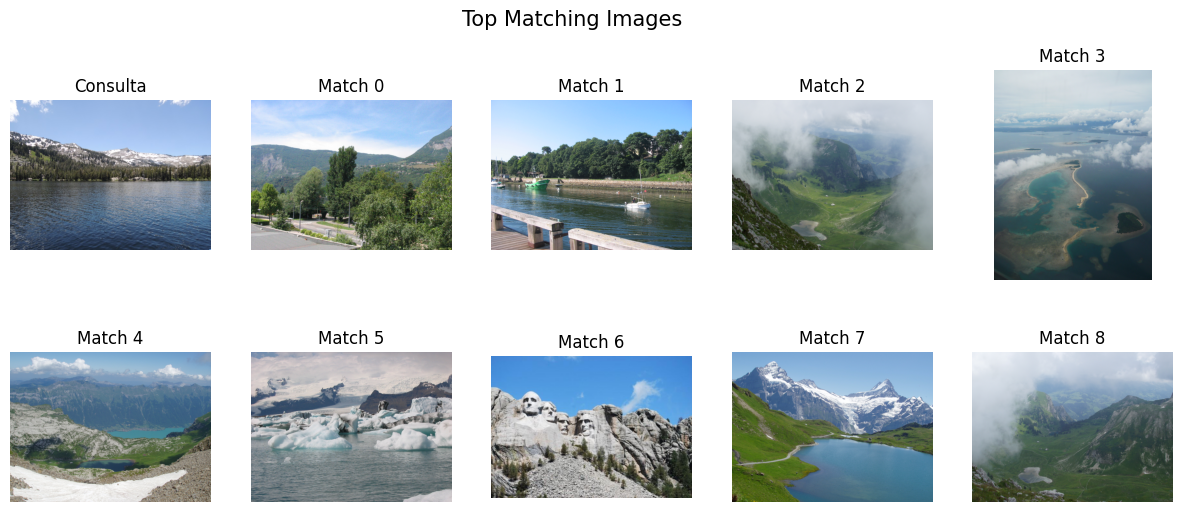

In [12]:
plot_10(df_query_CNN,PATH_TO_IMAGES)

Al igual que para el método handcrafted, se utiliza la funcion query_image para consultar por una imagen a elección.

### Metodo fusion

In [13]:
df_fusion_query = query_image_normal(df, IMAGE_EXAMPLE, measure=MEASURE, feature_type = "fusion")

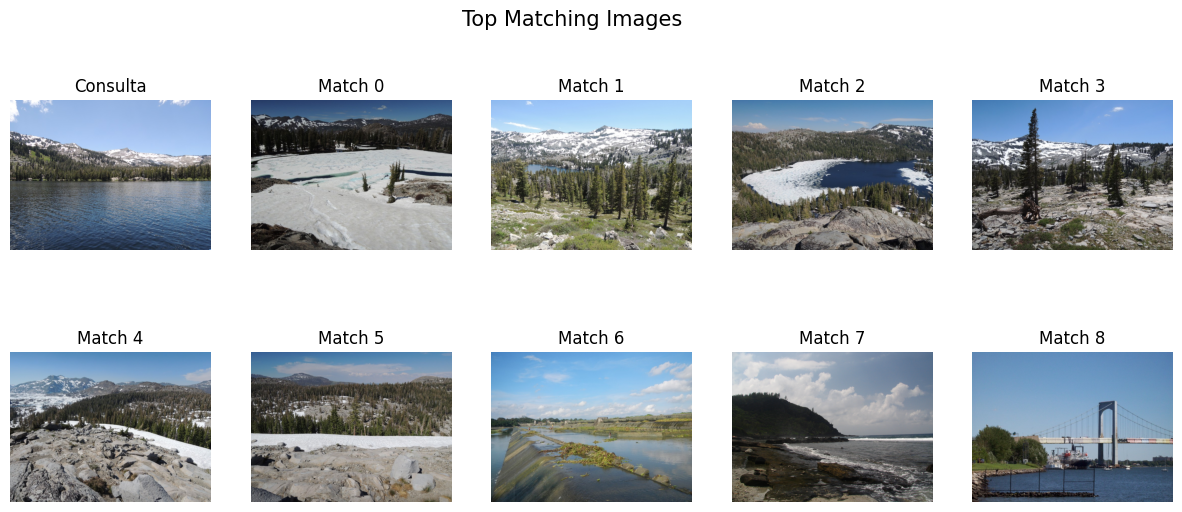

In [14]:
plot_10(df_fusion_query,PATH_TO_IMAGES)

## Comparación de los metodos y resultados


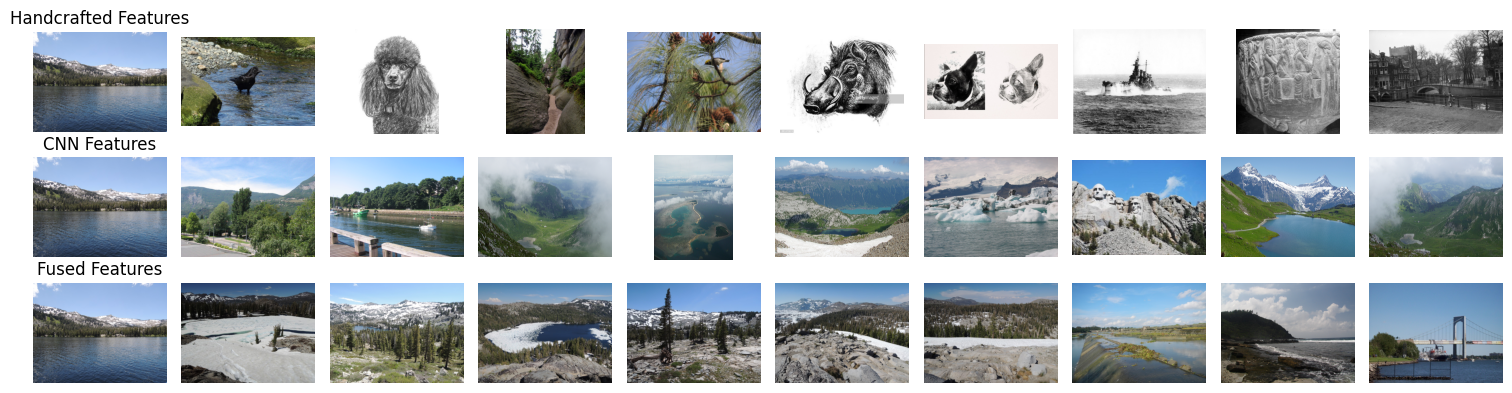

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
path_to_images = PATH_TO_IMAGES
 
# Create a figure with three rows and ten columns
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(15, 4))

# Iterate over each row and column to plot the images
for i in range(3):
    for j in range(10):
        if i == 0:
            axes[i, j].imshow(Image.open(f'{path_to_images}/{df_query_hand["image_name"][j]}'))
        elif i == 1:
            axes[i, j].imshow(Image.open(f'{path_to_images}/{df_query_CNN["image_name"][j]}'))
        else:
            axes[i, j].imshow(Image.open(f'{path_to_images}/{df_fusion_query["image_name"][j]}'))
        axes[i, j].axis('off')

# Set the title for each row
axes[0, 0].set_title('Handcrafted Features')
axes[1, 0].set_title('CNN Features')
axes[2, 0].set_title('Fused Features')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### Box Plot de Ranks

In [16]:

#matrix = similarity_matrix(df, measure="cosine", feature_type = "histogram")
#matrix_cnn = similarity_matrix(df, measure="cosine", feature_type = "CNN")
#matrix_fusion = similarity_matrix(df, measure="cosine", feature_type = "fusion")

In [17]:
#import joblib
#joblib.dump(matrix, "/mnt/c/Users/pyanez/Desktop/pablo/universidad/LabInt/dataset/similarity_matrix_histogram.pkl")
#joblib.dump(matrix_cnn, "../dataset/similarity_matrix_cnn.pkl")
#joblib.dump(matrix_fusion, "../dataset/similarity_matrix_fusion.pkl")
#matrix_fusion

In [5]:
import joblib
matrix = joblib.load("/mnt/c/Users/pyanez/Desktop/pablo/universidad/LabInt/dataset/similarity_matrix_histogram.pkl")
matrix

array([[0.        , 0.20792961, 0.17298329, ..., 0.168993  , 0.06602877,
        0.13881695],
       [0.20792961, 0.        , 0.04290539, ..., 0.25442272, 0.16046566,
        0.15299368],
       [0.17298329, 0.04290539, 0.        , ..., 0.2133764 , 0.12506098,
        0.11182171],
       ...,
       [0.168993  , 0.25442272, 0.2133764 , ..., 0.        , 0.09248215,
        0.06266314],
       [0.06602877, 0.16046566, 0.12506098, ..., 0.09248215, 0.        ,
        0.05643654],
       [0.13881695, 0.15299368, 0.11182171, ..., 0.06266314, 0.05643654,
        0.        ]])

In [6]:
matrix_cnn = joblib.load("/mnt/c/Users/pyanez/Desktop/pablo/universidad/LabInt/dataset/similarity_matrix_CNN.pkl")
matrix_cnn

array([[0.        , 0.16609001, 0.04163867, ..., 0.29356354, 0.29352826,
        0.37110251],
       [0.16609001, 0.        , 0.05826247, ..., 0.07082683, 0.08669192,
        0.10930037],
       [0.04163867, 0.05826247, 0.        , ..., 0.13761348, 0.14190733,
        0.19390017],
       ...,
       [0.29356354, 0.07082683, 0.13761348, ..., 0.        , 0.01676929,
        0.01750785],
       [0.29352826, 0.08669192, 0.14190733, ..., 0.01676929, 0.        ,
        0.01736057],
       [0.37110251, 0.10930037, 0.19390017, ..., 0.01750785, 0.01736057,
        0.        ]])

In [7]:
matrix_fusion = joblib.load("/mnt/c/Users/pyanez/Desktop/pablo/universidad/LabInt/dataset/similarity_matrix_fusion.pkl")
matrix_fusion

array([[0.        , 0.87089129, 0.87065384, ..., 0.99826592, 0.96360257,
        0.9554809 ],
       [0.87089129, 0.        , 0.70246336, ..., 0.99422252, 0.98060276,
        0.97136031],
       [0.87065384, 0.70246336, 0.        , ..., 1.00837728, 1.00738567,
        0.96372686],
       ...,
       [0.99826592, 0.99422252, 1.00837728, ..., 0.        , 0.80679701,
        0.77759315],
       [0.96360257, 0.98060276, 1.00738567, ..., 0.80679701, 0.        ,
        0.85573195],
       [0.9554809 , 0.97136031, 0.96372686, ..., 0.77759315, 0.85573195,
        0.        ]])

In [8]:
# evaluating ranking method
def evaluate_query(df, matrix_, image_query, normalized=True):
    # obtener la clase de la imagen
    image_class_ = SIFT.get_class(image_query)
    #print(image_class)
    # calcular similudes
    df_query_ = query_image(df, matrix_, image_query)
    #print(df.columns)
    # obtener los indices de las imagenes de la misma clase
    indexes = df_query_[df_query_["class"] == image_class_].index.values.tolist()
    #print(indexes)
    n_rel = len(indexes) - 1

    if normalized:
        NT = len(df)
        return 1/(n_rel*NT) * (sum(indexes) - (n_rel*(n_rel+1))/2)

    return 1/n_rel * sum(indexes)

image_example = df["image_name"][0]
evaluate_query(df, matrix, image_example, normalized=True)

0.07675075564779812

100%|██████████| 13491/13491 [01:02<00:00, 215.02it/s]


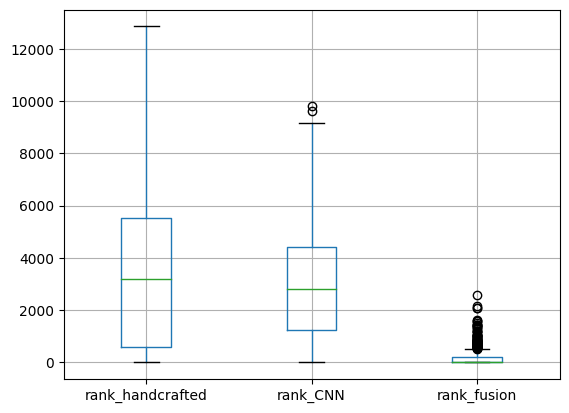

In [29]:
import tqdm
for i in tqdm.tqdm(range(len(df))):
    row = df.iloc[i,:]
    df.loc[i, "rank_handcrafted"] = evaluate_query(df, matrix, row["image_name"], normalized=False)

for i in tqdm.tqdm(range(len(df))):
    row = df.iloc[i,:]
    df.loc[i, "rank_CNN"] = evaluate_query(df, matrix_cnn, row["image_name"], normalized=False)

for i in tqdm.tqdm(range(len(df))):
    row = df.iloc[i,:]
    df.loc[i, "rank_fusion"] = evaluate_query(df, matrix_fusion, row["image_name"], normalized=False)

# drop non numeric columns
df_grouped = df.drop(["image_name", "similarity", "Nrank_handcrafted", "Nrank_CNN", "Nrank_fusion"], axis=1)
# group by class
df_grouped = df_grouped.groupby("class").mean()
# generate a box plot for each column
df_grouped.boxplot()
plt.show()

In [30]:
df_grouped.describe()

,rank_handcrafted,rank_CNN,rank_fusion
count,1700.000000,1700.000000,1700.000000
mean,3381.544337,2960.011163,145.996183
std,2794.454267,1965.402397,253.381632
min,1.000000,1.000000,1.000000
25%,578.444444,1255.861111,2.500000
50%,3190.727778,2813.494444,14.505556
75%,5526.461111,4429.769444,212.938889
max,12855.500000,9808.333333,2562.677778


100%|██████████| 13491/13491 [01:15<00:00, 178.13it/s]


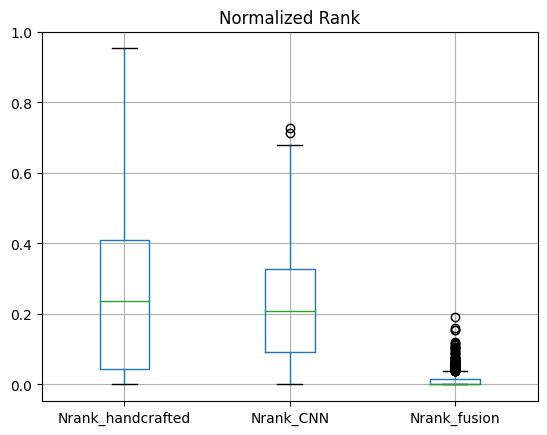

In [31]:
import tqdm
for i in tqdm.tqdm(range(len(df))):
    row = df.iloc[i,:]
    df.loc[i, "Nrank_handcrafted"] = evaluate_query(df, matrix, row["image_name"], normalized=True)

for i in tqdm.tqdm(range(len(df))):
    row = df.iloc[i,:]
    df.loc[i, "Nrank_CNN"] = evaluate_query(df, matrix_cnn, row["image_name"], normalized=True)

for i in tqdm.tqdm(range(len(df))):
    row = df.iloc[i,:]
    df.loc[i, "Nrank_fusion"] = evaluate_query(df, matrix_fusion, row["image_name"], normalized=True)

# drop non numeric columns
df_grouped = df.drop(["image_name", "rank_fusion", "rank_CNN", "rank_handcrafted", "similarity"], axis=1)
# group by class
df_grouped = df_grouped.groupby("class").mean()
# generate a box plot for each column
df_grouped.boxplot()
plt.title("Normalized Rank")
plt.show()


In [32]:
df_grouped.describe()

,Nrank_handcrafted,Nrank_CNN,Nrank_fusion
count,1700.000000,1700.000000,1700.000000
mean,0.250358,0.219112,0.010528
std,0.207071,0.145630,0.018739
min,0.000000,0.000000,0.000000
25%,0.042617,0.092718,0.000000
50%,0.236284,0.208175,0.000719
75%,0.409270,0.327979,0.015413
max,0.952783,0.726657,0.189584


### Curvas Precision-Recall

In [26]:
# get the class with more elements
df["class"].value_counts().median()

10.0

In [27]:
image_example = df["image_name"][0]
precision_recall(df, matrix_fusion, IMAGE_EXAMPLE, n_retrieved=100)


(0.08, 0.8888888888888888)

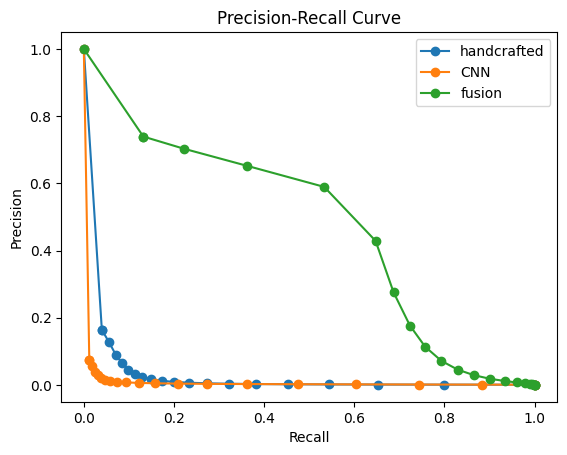

In [11]:
# calculate precision and recall for generating a
# precision recall graph for macro average
# to generate each point of the graph sweep the N parameter in a linspace from 3 to 13641
# (number of images in the dataset) make 30 points
# for each point calculate the precision and recall and then calculate the mean

import tqdm
import numpy as np
N = np.logspace(0, np.log10(len(df)), 20)
precision = {
    "handcrafted": [],
    "CNN": [],
    "fusion": []
}
recall = {
    "handcrafted": [],
    "CNN": [],
    "fusion": []
}
for N_ in tqdm.tqdm(N):
    precision_aux = 0
    recall_aux = 0
    for i in range(len(df)):
        row = df.iloc[i,:]
        precision_, recall_ = precision_recall(df, matrix, row["image_name"], n_retrieved=int(N_))
        precision_aux += precision_
        recall_aux += recall_
    precision["handcrafted"].append(precision_aux/len(df))
    recall["handcrafted"].append(recall_aux/len(df))

    precision_aux = 0
    recall_aux = 0
    for i in range(len(df)):
        row = df.iloc[i,:]
        precision_, recall_ = precision_recall(df, matrix_cnn, row["image_name"], n_retrieved=int(N_))
        precision_aux += precision_
        recall_aux += recall_
    precision["CNN"].append(precision_aux/len(df))
    recall["CNN"].append(recall_aux/len(df))

    precision_aux = 0
    recall_aux = 0
    for i in range(len(df)):
        row = df.iloc[i,:]
        precision_, recall_ = precision_recall(df, matrix_fusion, row["image_name"], n_retrieved=int(N_))
        precision_aux += precision_
        recall_aux += recall_
    precision["fusion"].append(precision_aux/len(df))
    recall["fusion"].append(recall_aux/len(df))


# # plot the precision recall graph with dots in each point
# # add the points (1,0) and (0,1) to the graph
for key in precision.keys():
    recall[key].append(1)
    precision[key].append(0)
    recall[key].insert(0, 0)
    precision[key].insert(0, 1)


plt.plot(recall["handcrafted"], precision["handcrafted"], "o-", label="handcrafted")
plt.plot(recall["CNN"], precision["CNN"], "o-", label="CNN")
plt.plot(recall["fusion"], precision["fusion"], "o-", label="fusion")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


## Conclusiones